In [15]:
import pandas as pd
import matplotlib.pyplot as plt

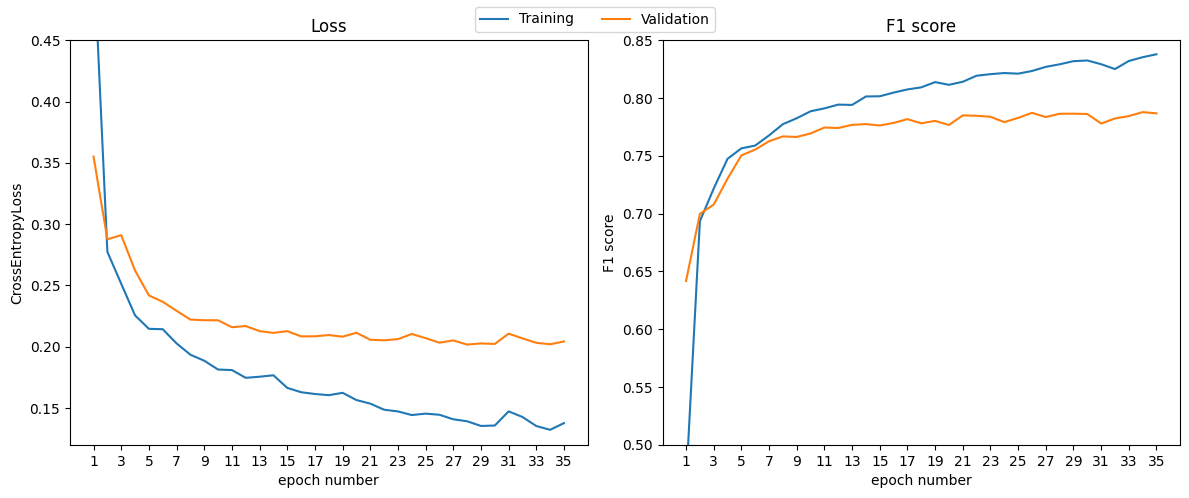

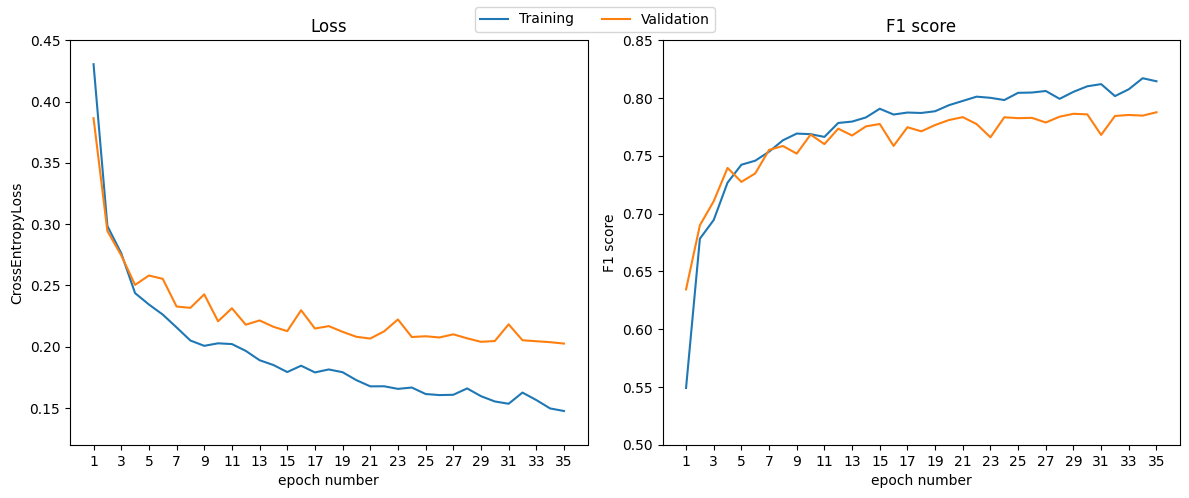

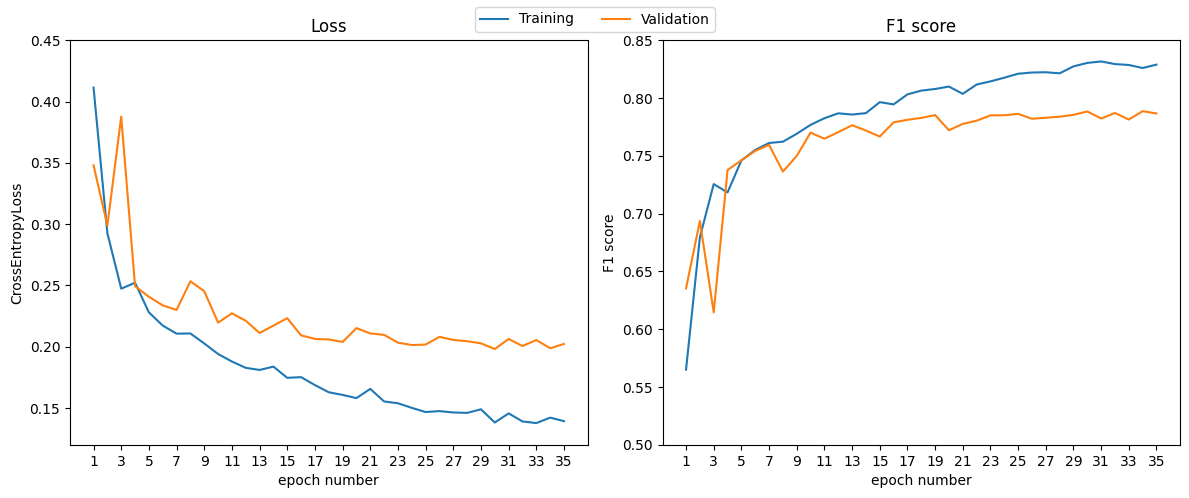

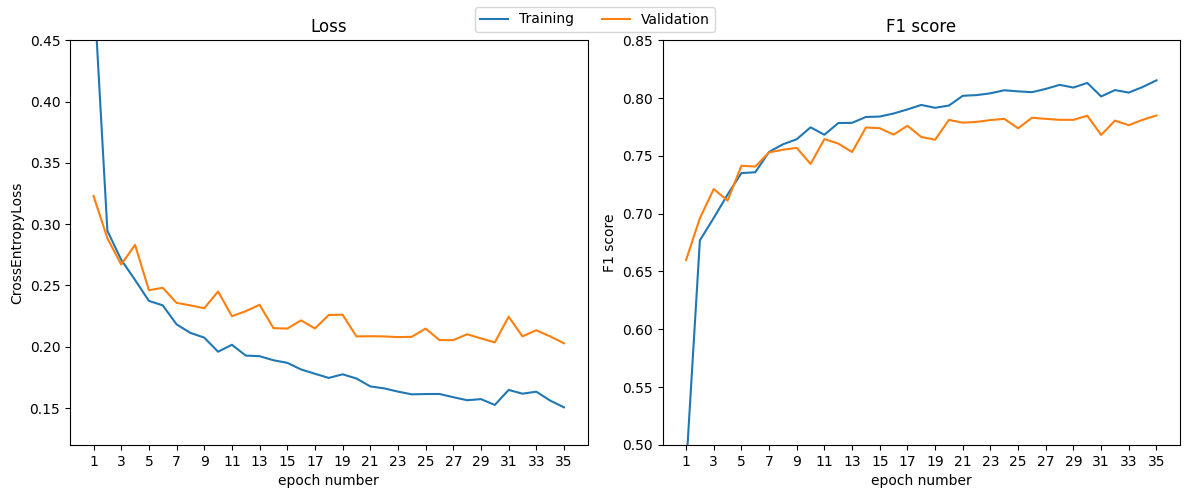

In [16]:
model_names = ['UNet11_e35_s256_b9_noaugm', 'UNet11_e35_s256_b9_jit', 'UNet11_prep_e35_s256_b9_noaugm', 'UNet11_prep_e35_s256_b9_jit']
for nm_model in model_names:
    df = pd.read_csv('models/'+nm_model+'_stats.csv')
    
    fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(12, 5))
    plt.setp((ax1,ax2), xticks=range(1, len(df['epoch number']), 2))
    ax1.plot(df['epoch number'],df['train loss'], label='Training')
    ax1.plot(df['epoch number'],df['validation loss'], label='Validation')
    ax1.set_title("Loss")
    ax1.set_ylabel('CrossEntropyLoss')
    ax1.set_ylim([.12, .45])
    ax1.set_xlabel('epoch number')
    ax2.plot(df['epoch number'],df['train f1 score'])
    ax2.plot(df['epoch number'],df['validation f1 score'])
    ax2.set_title("shares x with main")
    ax2.set_title("F1 score")
    ax2.set_ylabel('F1 score')
    ax2.set_ylim([.5, .85])
    ax2.set_xlabel('epoch number')
    fig.tight_layout()
    fig.legend(*ax1.get_legend_handles_labels(),
                loc='upper center', ncol=4)
    plt.savefig('models/'+nm_model+'_plot.jpg')
    